Kullanılan Cihaz: cuda
Sınıflar: ['empty', 'occupied']


c:\Users\edize\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\edize\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\edize/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth


100.0%



--- Eğitim Başlıyor ---
Epoch 1/3
train Loss: 0.0450 Acc: 0.9965
test Loss: 0.0020 Acc: 0.9991
Epoch 2/3
train Loss: 0.0041 Acc: 0.9993
test Loss: 0.0007 Acc: 1.0000
Epoch 3/3
train Loss: 0.0062 Acc: 0.9991
test Loss: 0.0030 Acc: 0.9986

Eğitim Tamamlandı. Süre: 16dk 6sn


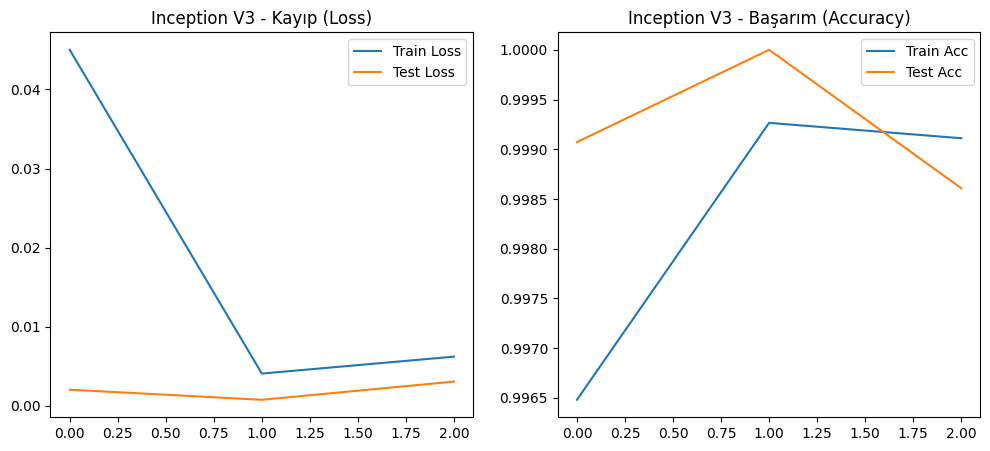


--- Test Sonuçları ve Karmaşıklık Matrisi ---


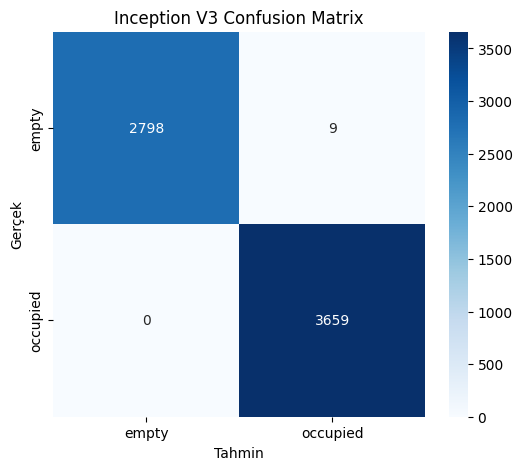

              precision    recall  f1-score   support

       empty     1.0000    0.9968    0.9984      2807
    occupied     0.9975    1.0000    0.9988      3659

    accuracy                         0.9986      6466
   macro avg     0.9988    0.9984    0.9986      6466
weighted avg     0.9986    0.9986    0.9986      6466



In [1]:
# ---------------------------------------------------------
# PROJE: Otopark Doluluk Tespiti (DeepPark)
# ÖĞRENCİ: Muhammet Emin Çapan - 23040301106
# MODEL: Inception V3
# ---------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
import time

# --- AYARLAR VE HİPERPARAMETRELER (Rapora Uygun) ---
DATA_DIR = r"C:\Users\edize\Final_Dataset"  # BURAYI KENDİ BİLGİSAYARINA GÖRE DEĞİŞTİR
IMG_SIZE = 299  # Inception V3 için zorunlu boyut
BATCH_SIZE = 32
LEARNING_RATE = 0.0001  # Inception için hassas LR
EPOCHS = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

# --- VERİ ÖN İŞLEME ---
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Veri Setlerini Yükle (Klasör yapısı: train/test -> empty/occupied)
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(f"Sınıflar: {class_names}")

# --- MODELİ OLUŞTUR (Inception V3) ---
model = models.inception_v3(pretrained=True)
# Son katmanı 2 sınıf (Empty/Occupied) için değiştir
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- EĞİTİM DÖNGÜSÜ ---
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

print("\n--- Eğitim Başlıyor ---")
start_time = time.time()

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    # Inception özel output (Auxiliary Logits)
                    outputs, aux_outputs = model(inputs)
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4 * loss2
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.item())
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.item())

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

time_elapsed = time.time() - start_time
print(f'\nEğitim Tamamlandı. Süre: {time_elapsed // 60:.0f}dk {time_elapsed % 60:.0f}sn')

# --- GRAFİKLERİ ÇİZ VE KAYDET ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Test Loss')
plt.title('Inception V3 - Kayıp (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history, label='Test Acc')
plt.title('Inception V3 - Başarım (Accuracy)')
plt.legend()
plt.savefig('InceptionV3_Egitim_Grafigi.png')
plt.show()

# --- CONFUSION MATRIX VE RAPOR ---
print("\n--- Test Sonuçları ve Karmaşıklık Matrisi ---")
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Inception V3 Confusion Matrix')
plt.ylabel('Gerçek')
plt.xlabel('Tahmin')
plt.savefig('InceptionV3_Confusion_Matrix.png')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))